In [238]:
# Data Set voorbereiden
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import pyodbc
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

DB = {"servername": "localhost\SQLEXPRESS",
      "database": "greatoutdoors"}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + 
                             ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

export_cursor = export_conn.cursor()


orders = pd.read_sql_query("SELECT * FROM orders;", export_conn)
products = pd.read_sql_query("SELECT * FROM Product;", export_conn)
product_type = pd.read_sql_query("SELECT * FROM product_type;", export_conn)
order_method = pd.read_sql_query("SELECT * FROM order_method;", export_conn)
country = pd.read_sql_query("SELECT * FROM country;", export_conn)

retailer_site = pd.read_sql_query("SELECT * FROM retailer_site;", export_conn)

orders = orders.merge(right=products, how="inner", left_on= "order_detail_product_number",right_on="PRODUCT_NUMBER").merge(right=product_type, how='inner', on="PRODUCT_TYPE_CODE").merge(right=retailer_site, how='inner', left_on="retailer_site_code", right_on="RETAILER_SITE_CODE").merge(order_method, left_on="order_method_code", right_on="order_method_code", how="inner").merge(country,left_on="COUNTRY_code", right_on="COUNTRY_CODE", how="inner")
# p = pd.merge(left=orders, right=retailer_site, left_on="retailer_site_code", right_on="RETAILER_SITE_code", how="inner")
product_quantities_yearly = orders.groupby(['order_year', 'order_detail_product_number', 'order_detail_unit_cost', 'order_detail_unit_sale_price', 'order_detail_unit_price', "retailer_site_code", "MARGIN_NUMBER", "PRODUCTION_COST_NUMBER", "PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "CITY_name", "order_method_name", "COUNTRY_EN"])['order_detail_quantity'].sum().reset_index()

product_quantities_yearly.columns =        ['Order Year', 'Product Number',              'order_detail_unit_cost', 'order_detail_unit_sale_price', 'order_detail_unit_price', "retailer_site_code", "MARGIN_NUMBER", "PRODUCTION_COST_NUMBER", "PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "CITY_name", "order_method_name", "COUNTRY_EN", 'Total Quantity Sold']

dummies_frame = pd.get_dummies(product_quantities_yearly.loc[:, ['PRODUCT_TYPE_EN', 'RETAILER_TYPE_EN', "PRODUCT_LINE_NAME", "CITY_name", "order_method_name", "COUNTRY_EN"]])

product_quantities_yearly = pd.concat([product_quantities_yearly, dummies_frame], axis=1)

product_quantities_yearly = product_quantities_yearly.drop(["PRODUCT_TYPE_EN", "RETAILER_TYPE_EN", "PRODUCT_LINE_NAME", "CITY_name", "order_method_name", "COUNTRY_EN"], axis=1)


# # pd.set_option('max_row', None)
pd.set_option('display.max_rows', 1000)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_columns', 90)

# # Afhankelijk - wat we willen voorspellen
# # Onafhankelijk - op basis van wat we willen voorspellen



# # X_train = Kolommen waarop je wilt trainen
# # X_test = Kolommen zoals x train

# # Y train = Resultaat die je wilt voorspellen
# # Y_test = Resultaat zoals y train

X = product_quantities_yearly.drop('Total Quantity Sold', axis=1)
y = product_quantities_yearly.loc[:, ['Total Quantity Sold']]



# pd.get_option('display.max_rows')

# X
# y
product_quantities_yearly # Onze dataset!
# orders
# dummies_frame

,Order Year,Product Number,order_detail_unit_cost,order_detail_unit_sale_price,order_detail_unit_price,retailer_site_code,MARGIN_NUMBER,PRODUCTION_COST_NUMBER,Total Quantity Sold,PRODUCT_TYPE_EN_Binoculars,PRODUCT_TYPE_EN_Climbing Accessories,PRODUCT_TYPE_EN_Cooking Gear,PRODUCT_TYPE_EN_Eyewear,PRODUCT_TYPE_EN_First Aid,PRODUCT_TYPE_EN_Golf Accessories,PRODUCT_TYPE_EN_Insect Repellents,PRODUCT_TYPE_EN_Irons,PRODUCT_TYPE_EN_Knives,PRODUCT_TYPE_EN_Lanterns,PRODUCT_TYPE_EN_Navigation,PRODUCT_TYPE_EN_Packs,PRODUCT_TYPE_EN_Putters,PRODUCT_TYPE_EN_Rope,PRODUCT_TYPE_EN_Safety,PRODUCT_TYPE_EN_Sleeping Bags,PRODUCT_TYPE_EN_Sunscreen,PRODUCT_TYPE_EN_Tents,PRODUCT_TYPE_EN_Tools,PRODUCT_TYPE_EN_Watches,PRODUCT_TYPE_EN_Woods,RETAILER_TYPE_EN_Department Store,RETAILER_TYPE_EN_Direct Marketing,RETAILER_TYPE_EN_Equipment Rental Store,RETAILER_TYPE_EN_Eyewear Store,RETAILER_TYPE_EN_Golf Shop,RETAILER_TYPE_EN_Outdoors Shop,RETAILER_TYPE_EN_Sports Store,RETAILER_TYPE_EN_Warehouse Store,PRODUCT_LINE_NAME_Camping Equipment,PRODUCT_LINE_NAME_Golf Equipment,PRODUCT_LINE_NAME_Mountaineering Equipment,PRODUCT_LINE_NAME_Outdoor Protection,PRODUCT_LINE_NAME_Personal Accessories,CITY_name_Aarhus,CITY_name_Albany,...,CITY_name_Tucson,CITY_name_Turku,CITY_name_Vancouver,CITY_name_Vantaa,CITY_name_Varsseveld,CITY_name_Venezia,CITY_name_Victoria,CITY_name_Wageningen,CITY_name_Washington,CITY_name_Whitehorse,CITY_name_Wien,CITY_name_Winnipeg,CITY_name_Wugu Shiang,CITY_name_Zaragoza,CITY_name_Zaventem,CITY_name_Zhengzhou,CITY_name_Zurich,order_method_name_E-mail,order_method_name_Fax,order_method_name_Mail,order_method_name_Sales visit,order_method_name_Special,order_method_name_Telephone,order_method_name_Web,COUNTRY_EN_Australia,COUNTRY_EN_Austria,COUNTRY_EN_Belgium,COUNTRY_EN_Brazil,COUNTRY_EN_Canada,COUNTRY_EN_China,COUNTRY_EN_Denmark,COUNTRY_EN_Finland,COUNTRY_EN_France,COUNTRY_EN_Germany,COUNTRY_EN_Italy,COUNTRY_EN_Japan,COUNTRY_EN_Korea,COUNTRY_EN_Mexico,COUNTRY_EN_Netherlands,COUNTRY_EN_Spain,COUNTRY_EN_Sweden,COUNTRY_EN_Switzerland,COUNTRY_EN_Taiwan,COUNTRY_EN_United Kingdom,COUNTRY_EN_United States
0,2020,1,4.38,5.19,6.59,59,0.33,4,1050,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,2020,1,4.38,5.26,6.59,21,0.33,4,1360,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2020,1,4.38,5.42,6.59,13,0.33,4,1160,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2020,1,4.38,5.48,6.59,335,0.33,4,3330,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False

In [227]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.15,
    random_state = 42
)
X_train
# y_test

,Order Year,Product Number,order_detail_unit_cost,order_detail_unit_sale_price,order_detail_unit_price,retailer_site_code,MARGIN_NUMBER,PRODUCTION_COST_NUMBER,PRODUCT_TYPE_EN_Binoculars,PRODUCT_TYPE_EN_Climbing Accessories,PRODUCT_TYPE_EN_Cooking Gear,PRODUCT_TYPE_EN_Eyewear,PRODUCT_TYPE_EN_First Aid,PRODUCT_TYPE_EN_Golf Accessories,PRODUCT_TYPE_EN_Insect Repellents,PRODUCT_TYPE_EN_Irons,PRODUCT_TYPE_EN_Knives,PRODUCT_TYPE_EN_Lanterns,PRODUCT_TYPE_EN_Navigation,PRODUCT_TYPE_EN_Packs,PRODUCT_TYPE_EN_Putters,PRODUCT_TYPE_EN_Rope,PRODUCT_TYPE_EN_Safety,PRODUCT_TYPE_EN_Sleeping Bags,PRODUCT_TYPE_EN_Sunscreen,PRODUCT_TYPE_EN_Tents,PRODUCT_TYPE_EN_Tools,PRODUCT_TYPE_EN_Watches,PRODUCT_TYPE_EN_Woods,RETAILER_TYPE_EN_Department Store,RETAILER_TYPE_EN_Direct Marketing,RETAILER_TYPE_EN_Equipment Rental Store,RETAILER_TYPE_EN_Eyewear Store,RETAILER_TYPE_EN_Golf Shop,RETAILER_TYPE_EN_Outdoors Shop,RETAILER_TYPE_EN_Sports Store,RETAILER_TYPE_EN_Warehouse Store,PRODUCT_LINE_NAME_Camping Equipment,PRODUCT_LINE_NAME_Golf Equipment,PRODUCT_LINE_NAME_Mountaineering Equipment,PRODUCT_LINE_NAME_Outdoor Protection,PRODUCT_LINE_NAME_Personal Accessories,CITY_name_Aarhus,CITY_name_Albany,CITY_name_Albuquerque,CITY_name_Alexandria,CITY_name_Amstelveen,CITY_name_Amsterdam,CITY_name_Anaheim,CITY_name_Anchorage,CITY_name_Annecy,CITY_name_Antwerpen,CITY_name_Arlon,CITY_name_Arvika,CITY_name_Atlanta,CITY_name_Atlantic City,CITY_name_Austin,CITY_name_Baltimore,CITY_name_Banchiao City,CITY_name_Barcelona,CITY_name_Basel,CITY_name_Baton Rouge,CITY_name_Beets,CITY_name_Beijing,CITY_name_Bellinzona,CITY_name_Bergamo,CITY_name_Berlin,CITY_name_Bilbao,CITY_name_Billings,CITY_name_Birkerod,CITY_name_Birmingham,CITY_name_Bismark,CITY_name_Boise,CITY_name_Bollnas,CITY_name_Bologna,CITY_name_Bonn,CITY_name_Bordeaux,CITY_name_Boston,CITY_name_Boulder,CITY_name_Bremen,CITY_name_Brighton,CITY_name_Brisbane,CITY_name_Bristol,CITY_name_Bruxelles,CITY_name_Buffalo,CITY_name_Cairns,CITY_name_Cancun,CITY_name_Carson City,CITY_name_Casper,CITY_name_Cedar Rapids,CITY_name_Chaiwan,CITY_name_Chamonix,CITY_name_Chapel Hill,CITY_name_Charleroi,CITY_name_Charleston,CITY_name_Charlottetown,CITY_name_Chattanooga,CITY_name_Chengdu,CITY_name_Chicago,CITY_name_Chungho City,CITY_name_Cincinnati,CITY_name_Dallas,CITY_name_Dawson Creek,CITY_name_Den Haag,CITY_name_Denver,CITY_name_Detroit,CITY_name_Deventer,CITY_name_Distrito Federal,CITY_name_Dover,CITY_name_Dresden,CITY_name_Duluth,CITY_name_Dusseldorf,CITY_name_Erfurt,CITY_name_Firenze,CITY_name_Frankfurt,CITY_name_Fredericton,CITY_name_Freiburg,CITY_name_Fribourg,CITY_name_Fukuoka-shi,CITY_name_Geneve,CITY_name_Genova,CITY_name_Goteborg,CITY_name_Graz,CITY_name_Grenoble,CITY_name_Groningen,CITY_name_Guadalajara,CITY_name_Guangzhou,CITY_name_Halifax,CITY_name_Hamburg,CITY_name_Hangzhou,CITY_name_Hannover,CITY_name_Hanover,CITY_name_Hartford,CITY_name_Helsinki,CITY_name_Hiroshima-shi,CITY_name_Honolulu,CITY_name_Houston,CITY_name_Hsinchu,CITY_name_Hull,CITY_name_Incheon,CITY_name_Independence,CITY_name_Indianapolis,CITY_name_Innsbruck,CITY_name_Ischgl,CITY_name_Jackson,CITY_name_Jacksonville,CITY_name_Karlstad,CITY_name_Kiel,CITY_name_Kirchberg,CITY_name_Klosterneuburg,CITY_name_Kobenhavn,CITY_name_Kolding,CITY_name_Kottingbrunn,CITY_name_Kwangju,CITY_name_Lake Placid,CITY_name_Laren,CITY_name_Las Vegas,CITY_name_Lausanne,CITY_name_Leuven,CITY_name_Liege,CITY_name_Lincoln,CITY_name_Linz,CITY_name_Little Rock,CITY_name_Logrono,CITY_name_London,CITY_name_Loorsdorf,CITY_name_Los Angeles,CITY_name_Ludvika,CITY_name_Lugano,CITY_name_Lyon,CITY_name_Maarssen,CITY_name_Madison,CITY_name_Madrid,CITY_name_Magdeburg,CITY_name_Mainz,CITY_name_Malmo,CITY_name_Mannheim,CITY_name_Marken,CITY_name_Marseille,CITY_name_Melbourne,CITY_name_Mexico City,CITY_name_Miami,CITY_name_Milano,CITY_name_Milton Keynes,CITY_name_Molndal,CITY_name_Monterey,CITY_name_Montpelier,CITY_name_Montreal,CITY_name_Muiden,CITY_name_Munchen,CITY_name_Nantes,CITY_name_Napoli,CITY

In [ ]:
reg_model = linear_model.LinearRegression()
reg_model = LinearRegression().fit(X_train, y_train)

reg_model

LinearRegression()

In [ ]:
y_pred = reg_model.predict(X_test)
y_pred

array([[164.95264816],
       [342.05802536],
       [ 64.67811584],
       ...,
       [226.24668884],
       [235.23041916],
       [208.69117355]])

In [230]:
prediction_df = pd.DataFrame(y_pred)

prediction_df = prediction_df.rename(columns = {0 : "Voorspelde Verkoopcijfers"})

prediction_df

,Voorspelde Verkoopcijfers
0,164.952648
1,342.058025
2,64.678116
3,152.770962
4,340.815008
...,...
6110,363.709576
6111,69.357609
6112,226.246689
6113,235.230419


In [231]:
pd.set_option('display.max_rows', 1000)
pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
y_test_prediction_merge = pd.concat([y_test.reset_index()['Total Quantity Sold'], prediction_df], axis = 1)
y_test_prediction_merge.loc[y_test_prediction_merge['Voorspelde Verkoopcijfers'].notna(), :]

,Total Quantity Sold,Voorspelde Verkoopcijfers
0,200,164.952648
1,120,342.058025
2,90,64.678116
3,120,152.770962
4,230,340.815008
5,210,76.032372
6,250,319.792297
7,160,332.220901
8,190,93.851669
9,650,624.734226


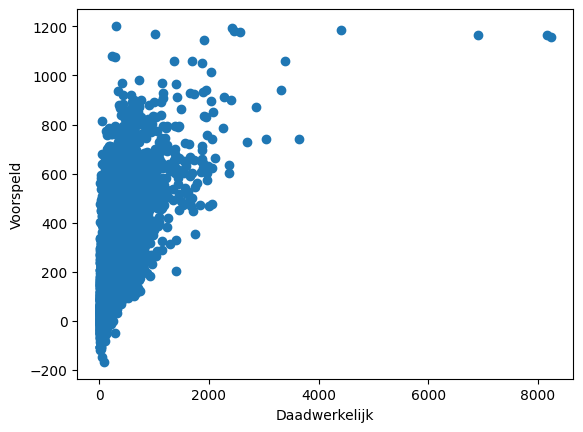

In [232]:
plt.scatter(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])

plt.xlabel('Daadwerkelijk')
plt.ylabel('Voorspeld')
plt.show()

In [233]:
mean_squared_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])


75210.71819019364

In [234]:
mean_absolute_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])

140.4984329897365

In [235]:
mean_absolute_percentage_error(y_test_prediction_merge['Total Quantity Sold'], y_test_prediction_merge['Voorspelde Verkoopcijfers'])

0.9181596769423517